In [420]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
from torch import nn
from tqdm import tqdm_notebook as tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")

In [395]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# preprocessing 

In [396]:
def preprocessing_X(dir):
    files = os.listdir(dir)
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        try:
            waveform, sample_rate = torchaudio.load(dir+f)
            features = torchaudio.transforms.MFCC()(waveform)
            X = torch.cat([X,torch.unsqueeze(features,0)],dim=0)
        except:
            print(f'file:{f} error')
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path,error_idx='train_01046'):
    Y = pd.read_csv(file_path)
    Y = Y[Y.Filename != error_idx]
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

In [397]:
X_train = preprocessing_X(X_train_dir)
#X_test = preprocessing_X(test_dir)
Y_train,Y_train_df = preprocessing_Y(Y_train_path)

file:train_01046.wav error

X shape: torch.Size([1199, 1, 40, 201])
Y_ont_hot shape (1199, 6)
Y_df shape (1199, 3)


# look some sample

In [398]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

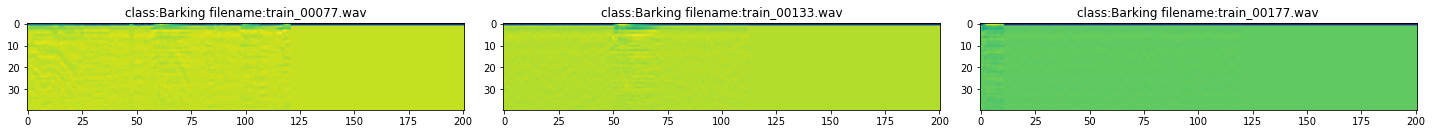

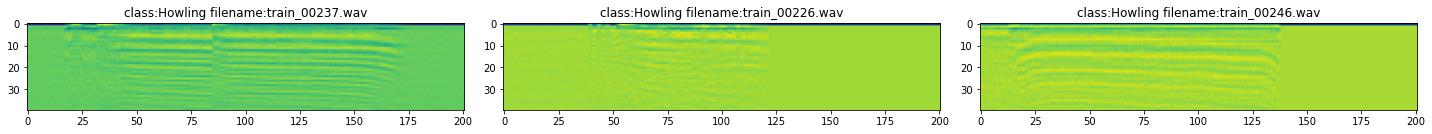

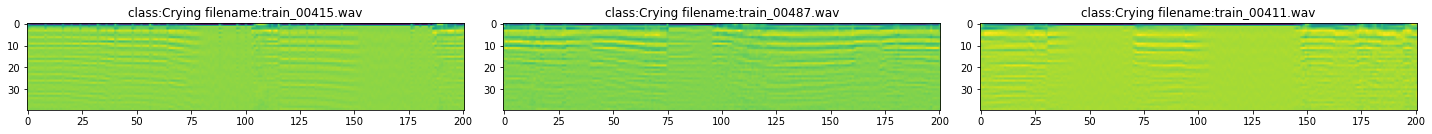

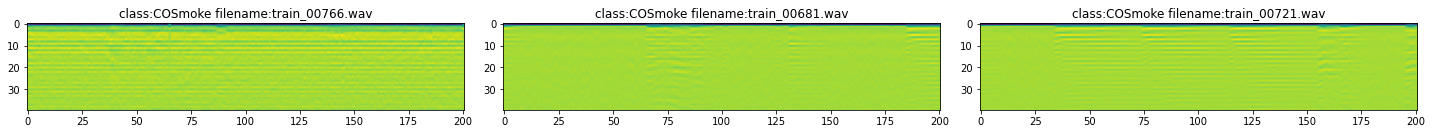

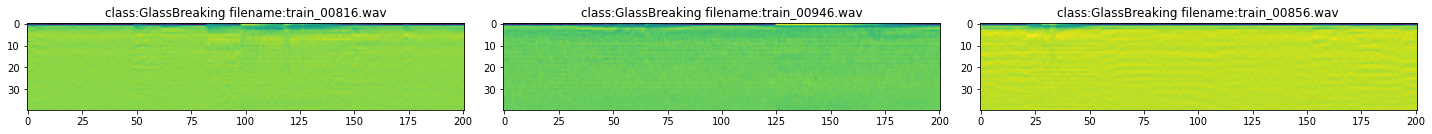

Other


<Figure size 1440x360 with 0 Axes>

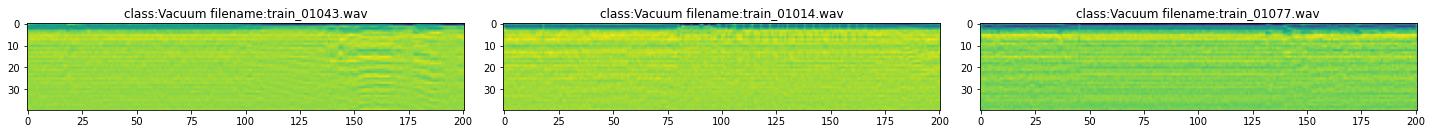

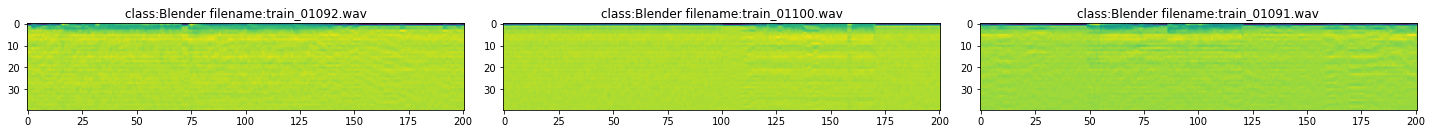

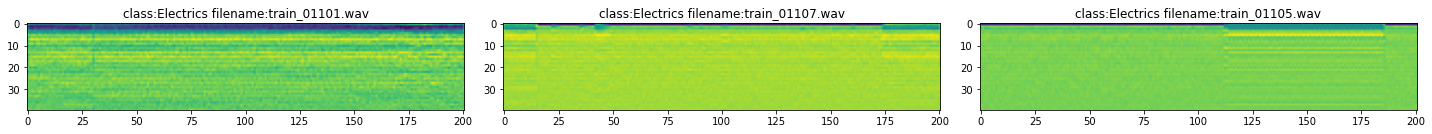

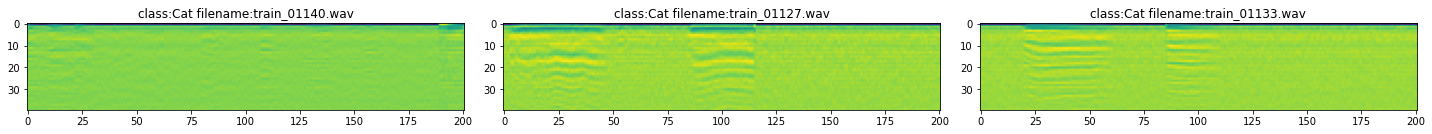

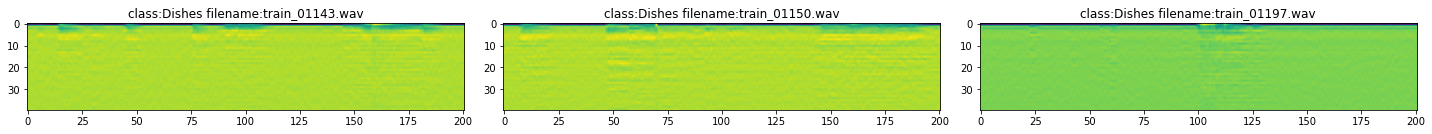

In [399]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# create pytorch dataloader and save

In [400]:
from torch.utils.data import TensorDataset,DataLoader
import numpy as np

total_data_len = X_train.shape[0]
train_percent = 0.8
train_size = int(train_percent*total_data_len)
train_idx = list(np.random.choice([*range(total_data_len)],size=train_size,replace=False))
vaild_idx = list(set([*range(total_data_len)]) - set(train_idx))
trainset = TensorDataset(torch.FloatTensor(X_train)[train_idx],torch.FloatTensor(Y_train)[train_idx])
vaildset = TensorDataset(torch.FloatTensor(X_train)[vaild_idx],torch.FloatTensor(Y_train)[vaild_idx])
train_iter = DataLoader(trainset,batch_size=64)
vaild_iter = DataLoader(vaildset,batch_size=64)
torch.save(train_iter, 'train_iter.pt')
torch.save(vaild_iter, 'vaild_iter.pt')

In [401]:
for bx,by in train_iter:
    print(bx.shape) # batch,channel,n_mfcc,time
    print(by.shape) # batch,n_class
    break

torch.Size([64, 1, 40, 201])
torch.Size([64, 6])


# define model

In [402]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*7*47,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,6)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1,16*7*47)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x
    
    def look_feature_map(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        return x

In [403]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
model = LeNet()
writer.add_graph(model,[bx])
writer.close()
# cmd: tensorboard --logdir=runs

# train model

In [404]:
# train_step
def train_step(model,train_iter,loss_fn,optimizer):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

# valid_step  
def valid_step(model,vaild_iter,loss_fn,optimizer):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    return roc_auc_score(y.detach().cpu().numpy(),model(x).detach().cpu().numpy())


# train_loop
def train(model,optimizer,loss_fn,max_epochs=300,log_interval=10):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer)
            valid_loss,valid_auc = valid_step(model,train_iter,loss_fn,optimizer)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5264, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


epoch:0 train_loss:0.0692 valid_loss:0.0566 train_auc:0.7022 valid_auc:0.8760
epoch:10 train_loss:0.0060 valid_loss:0.0045 train_auc:0.9946 valid_auc:0.9943
epoch:20 train_loss:0.0011 valid_loss:0.0010 train_auc:0.9973 valid_auc:0.9973
epoch:30 train_loss:0.0007 valid_loss:0.0007 train_auc:0.9990 valid_auc:0.9991
epoch:40 train_loss:0.0004 valid_loss:0.0004 train_auc:0.9994 valid_auc:0.9994
epoch:50 train_loss:0.0003 valid_loss:0.0003 train_auc:0.9994 valid_auc:0.9995
epoch:60 train_loss:0.0003 valid_loss:0.0002 train_auc:0.9996 valid_auc:0.9997
epoch:70 train_loss:0.0001 valid_loss:0.0001 train_auc:0.9999 valid_auc:0.9999
epoch:80 train_loss:0.0001 valid_loss:0.0001 train_auc:1.0000 valid_auc:1.0000
epoch:90 train_loss:0.0001 valid_loss:0.0000 train_auc:1.0000 valid_auc:1.0000



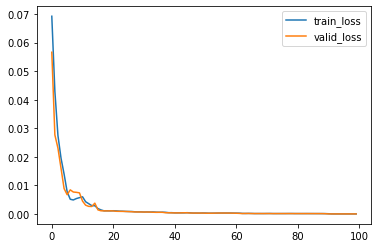

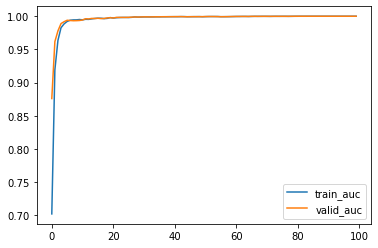

train done


In [405]:
device = 'cuda:0'
model = LeNet().to(device)
print(model)
optimizer = Adam(model.parameters(),lr=1e-3)
loss_fn = nn.SmoothL1Loss()
model = train(model,optimizer,loss_fn,max_epochs=100,log_interval=10)
torch.save(model,'model.pt')
print('train done')

# model infernce test

In [406]:
for bx,by in train_iter:
    bx = bx.to(device)
    by = by.to(device)
    y_hat = model(bx)
    break

In [407]:
y_hat.argmax(axis=1)

tensor([5, 1, 1, 2, 5, 3, 5, 2, 0, 4, 5, 5, 2, 2, 3, 0, 4, 3, 1, 3, 0, 5, 5, 5,
        0, 0, 2, 3, 3, 2, 0, 0, 0, 4, 0, 3, 0, 2, 2, 1, 3, 2, 3, 4, 3, 3, 5, 0,
        0, 0, 0, 5, 1, 5, 2, 0, 1, 2, 0, 4, 1, 2, 3, 5], device='cuda:0')

In [408]:
by.argmax(axis=1)

tensor([5, 1, 1, 2, 5, 3, 5, 2, 0, 4, 5, 5, 2, 2, 3, 0, 4, 3, 1, 3, 0, 5, 5, 5,
        0, 0, 2, 3, 3, 2, 0, 0, 0, 4, 0, 3, 0, 2, 2, 1, 3, 2, 3, 4, 3, 3, 5, 0,
        0, 0, 0, 5, 1, 5, 2, 0, 1, 2, 0, 4, 1, 2, 3, 5], device='cuda:0')

In [409]:
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Vacuum'}

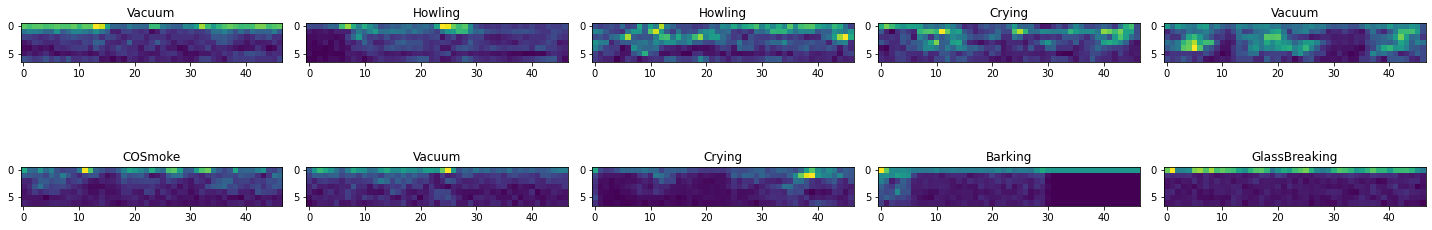

In [417]:
plt.figure(figsize=(20,5))
i=0
for x,y in zip(bx[:10],by[:10]):
    x = x.to(device)
    feature_map = model.look_feature_map(torch.unsqueeze(x,0))
    plt.subplot(2,5,i+1)
    feature_map = feature_map.sum(axis=1)
    plt.imshow(feature_map.detach().cpu().numpy()[0,:,:])
    plt.title(map_dict[y.argmax().item()])
    i += 1
plt.tight_layout()
plt.show()

In [418]:
model = model.to('cpu')
torch.save(model,'model.pt')
print('model save done')

model save done


# submit

In [422]:
# load model
model = torch.load('model.pt').cuda()
print('use model is:',model)

# test_data_dir
test_data_dir = 'public_test/public_test/'

# inference for loop
files = os.listdir(test_data_dir)
n = 10
sample_submit = pd.read_csv('sample_submission.csv')
i = 0
for f in tqdm(files[:n]):
    waveform, sample_rate = torchaudio.load(test_data_dir+f)
    features = torchaudio.transforms.MFCC()(waveform)
    X = torch.unsqueeze(features,0).cuda()
    y_hat = model(X).detach().cpu().numpy()
    sample_submit.iloc[[i],1:] = y_hat
    i += 1
    gc.collect()

# save
sample_submit.to_csv('submit.csv',index=False)
print('done')

use model is: LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5264, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)



done
